
# Experiments with PDFA Learning

The goal of the notebook is to experiment with manipulating and learning pdfa.

## Generating traces from a learning target

We will be defining a model to learn, and then sampling from it such that we can learn from the generated corpus.

### Target Definition

Here, we define a three-state PDFA in a YAML configuration file:

In [31]:
%load_ext autoreload
%autoreload 2

from pygments import highlight
from pygments.lexers import YamlLexer
from pygments.formatters import HtmlFormatter
import IPython
config_file = 'wombats/config/pdfa_self_driving_config.yaml'

with open(config_file) as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, YamlLexer(), formatter)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading into Wombats®

Now that we have defined an automaton, we can load it into wombats®:

In [2]:
from wombats.automaton import active_automata
from sklearn.model_selection import train_test_split
import numpy as np


pdfa_model = active_automata.get(automaton_type='PDFA',
                                 graph_data=config_file)

Now that we have built the model, let's see what it looks like:

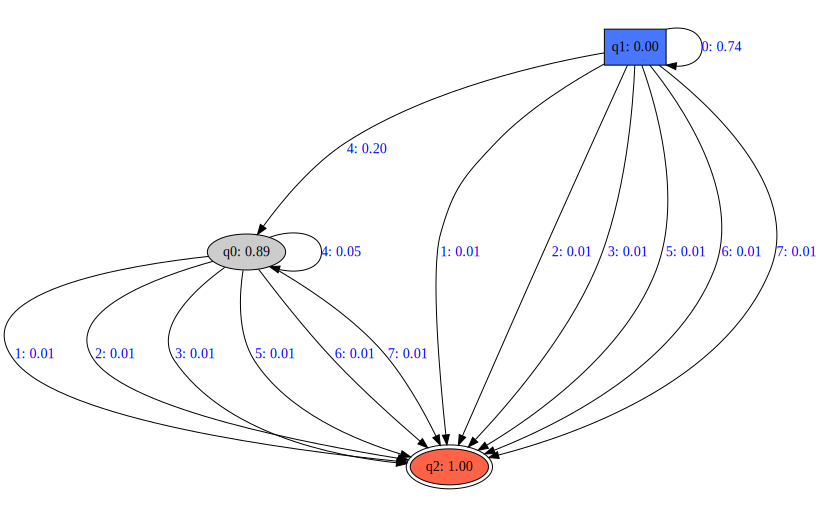

In [3]:
pdfa_model.draw_IPython()

### Sampling from the target PDFA

With the model built, we can sample a trace from it:

In [5]:
(trace, trace_len,
 trace_prob) = pdfa_model.generate_trace(pdfa_model.start_state, N=20)
print("Trace:", trace)
print("Probability of trace in language of the model:", trace_prob)

[0.2]
Trace: [4]
Probability of trace in language of the model: [0.2]


### Creating a test / training split

Here, we can generate all of the data for our learning algorithms to use:

In [12]:
num_samples = 1000
max_trace_length = 30
(traces,
 trace_lengths,
 trace_probs) = pdfa_model.generate_traces(num_samples, N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.1
(traces_train, traces_test,
 traceLengths_train, traceLengths_test,
 trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                         trace_lengths,
                                                         trace_probs,
                                                         test_size=test_size)

# Write learning data to files for inference
num_traces_train = len(traces_train)
num_traces_test = len(traces_test)
pdfa_model.write_traces_to_file(traces_train, num_traces_train,
                                traceLengths_train,
                                f_name='PDFASamples_train.swag')
pdfa_model.write_traces_to_file(traces_test, num_traces_test,
                                traceLengths_test,
                                f_name='PDFASamples_test.swag')

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


Now that we have built the model, let's see what it looks like:

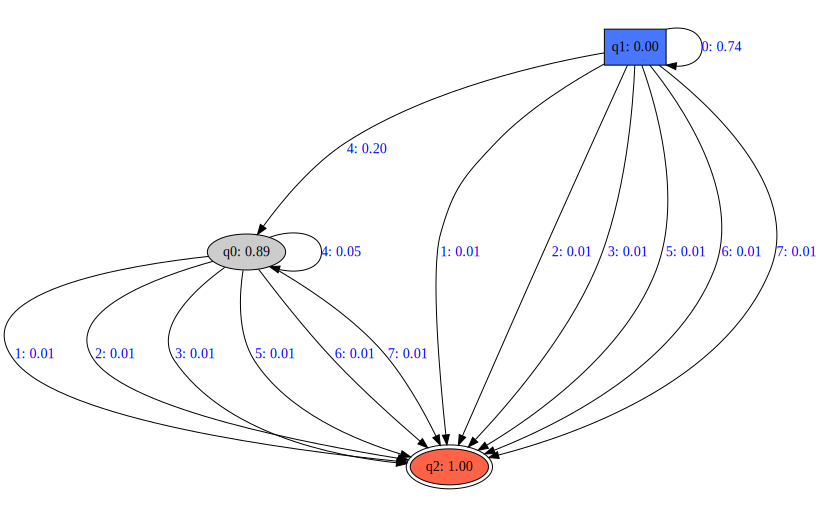

In [13]:
pdfa_model.draw_IPython()

## Learning a PDFA with Flexfringe

Two choices: Using it via Python function calls, or working with the command line.

### Step 1

Install all dependencies and compile flexfringe (development branch due to some technicalities using WIFEXITED macro used for the SAT solver's process)

In [ ]:
# for the C++ code
!apt install graphviz
!apt install libgsl-dev
!apt install libpopt-dev

# for visualization and notebook interface
!pip install graphviz

# Stamina data
!wget http://stamina.chefbe.net/downloads/grid.tar.gz
!tar xfz grid.tar.gz

# cloning the repository
!rm -rf dfasat
!git clone https://bitbucket.org/chrshmmmr/dfasat.git

In [ ]:
# building the repository
# it is important to check out the development branch on colab
!cd dfasat && git checkout  && make clean all

### Step 2 
Import flexfringe tool interface

In [14]:
%autoreload 2
from wombats.learning import FlexfringeInterface

flexfringe = FlexfringeInterface()

### Step 3

Run grammatical inference using the flexfringe tool with the filename and named arguments just as described in help.

In [15]:
flexfringe.infer_model(training_file='')

no learning options specified, printing tool help:
welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe -h=alergia -d=alergia_data --output-dir=./dfa PDFASamples_train.swag 
sat_program : 
valid: alergia
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic alergia
Creating apta using evaluation class alergia_data
batch mode selected
reading data finished, processing:
dfasat running x1366  x1000  x728  x528  x390  m53  m8  m7  m6  m5  x76  m5  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  m1  

found intermediate solution with 7 and 7 red states
No valid solver specified, skipping...



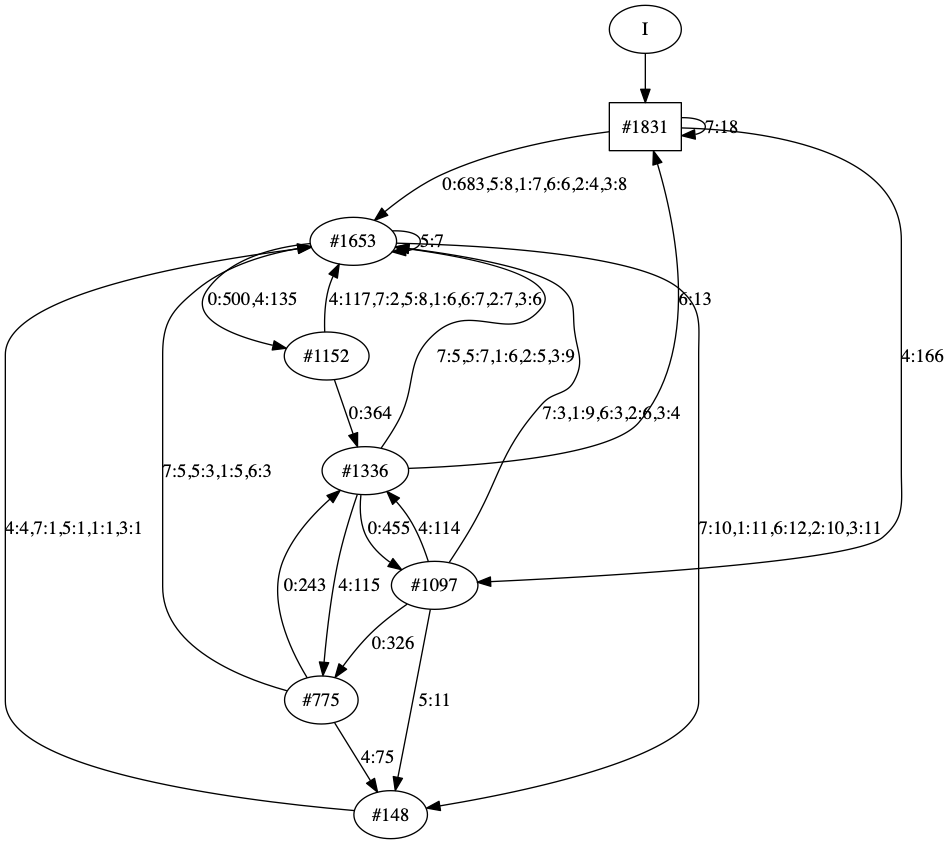

In [16]:
data = flexfringe.infer_model(training_file='PDFASamples_train.swag',
                              h='alergia',
                              d='alergia_data')
flexfringe.draw_IPython(data)

## Loading Learned Flexfringe Model into Wombats

We first must get the output from flexfringe and convert it into a proper FDFA:

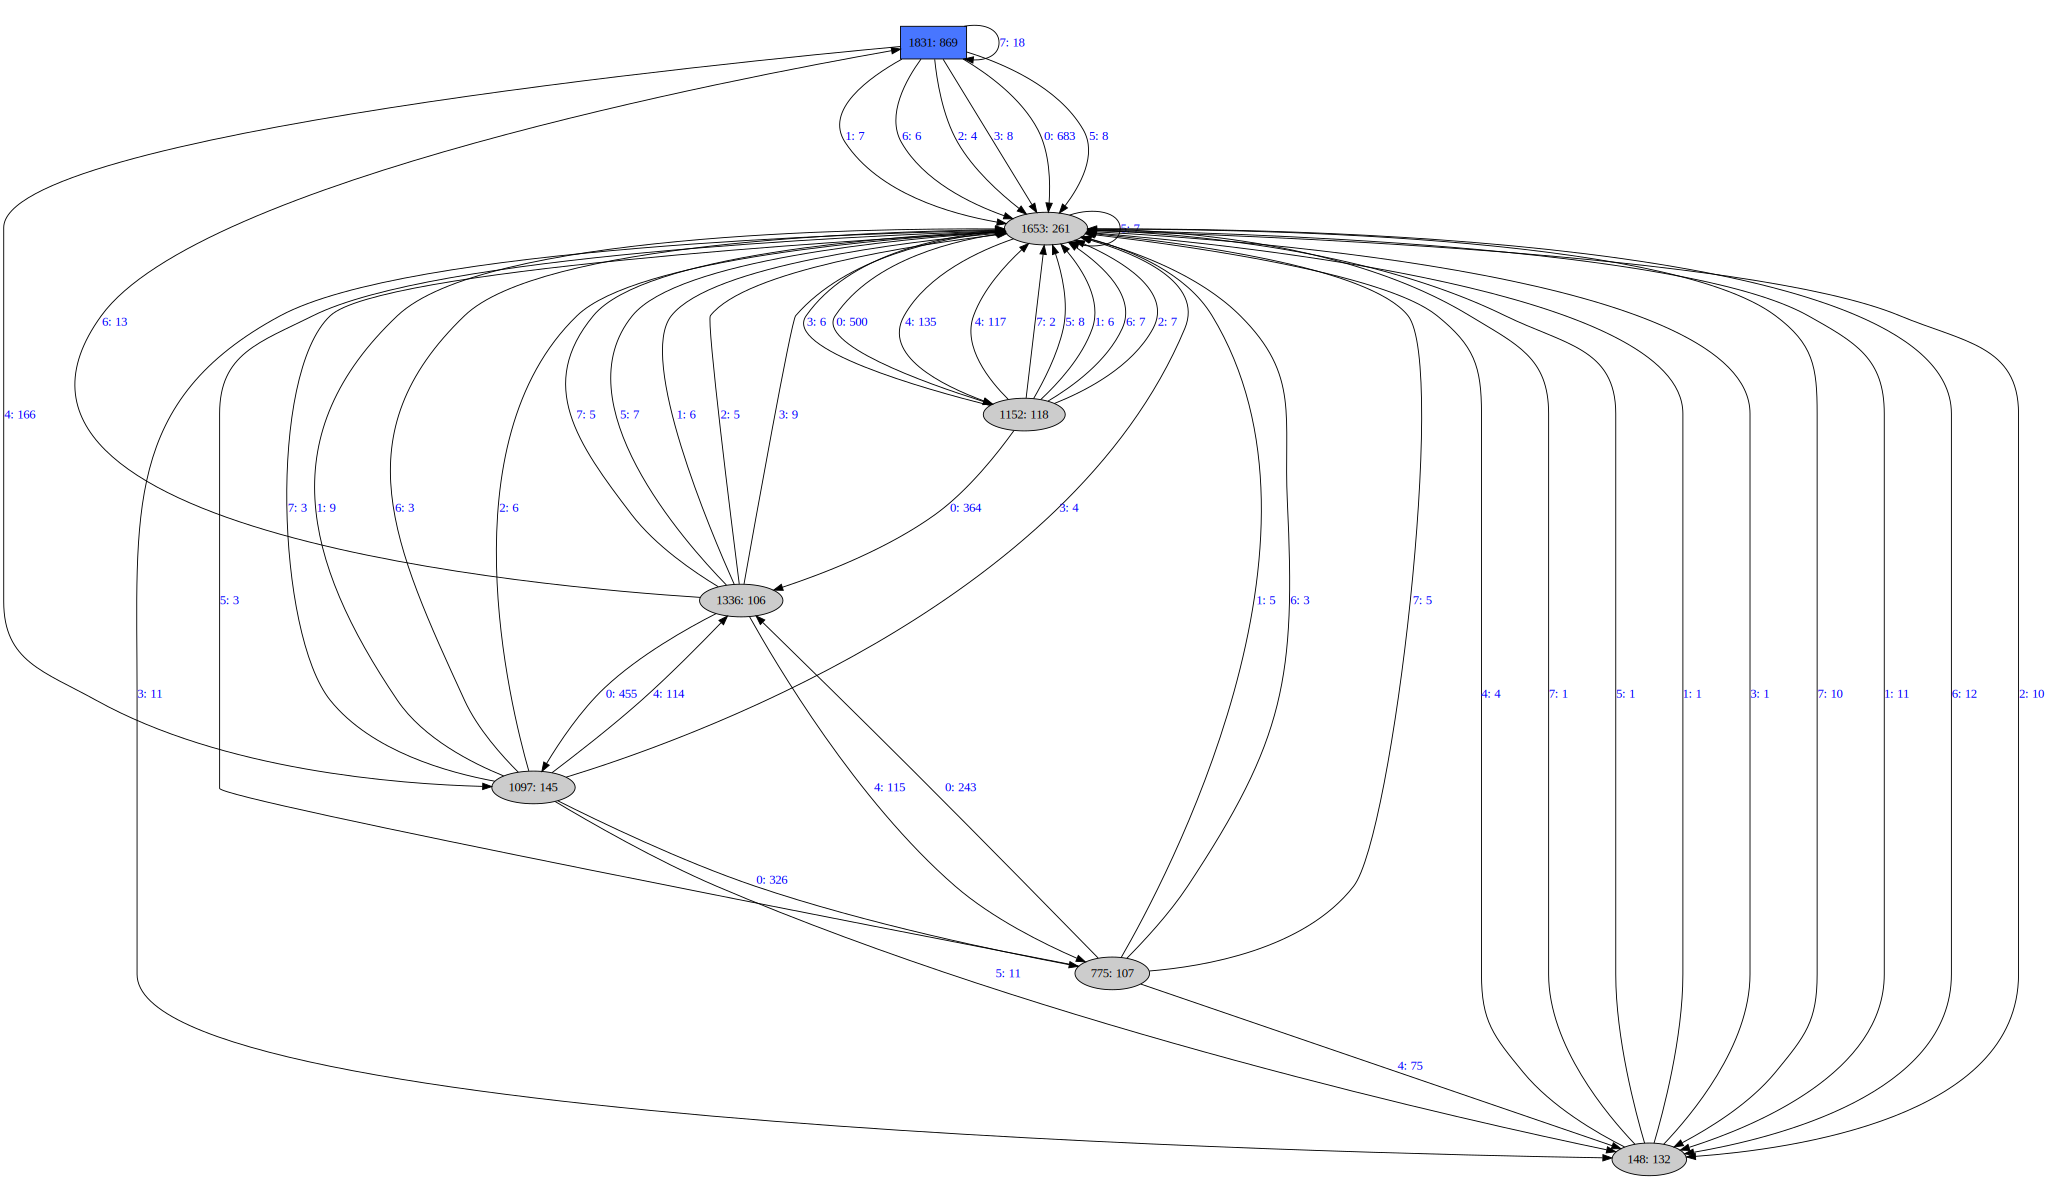

In [17]:
%autoreload 2

# learned_fdfa = active_automata.get(automaton_type='FDFA',
#                                    graph_data=data,
#                                    graph_data_format='dot_string')
# or
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe.learned_model_filepath,
                                   graph_data_format='dot_file')
learned_fdfa.draw_IPython()

With the FDFA loaded in, we use wombat conversion utilities to convert the FDFA to a PDFA (the same format as our learning target):

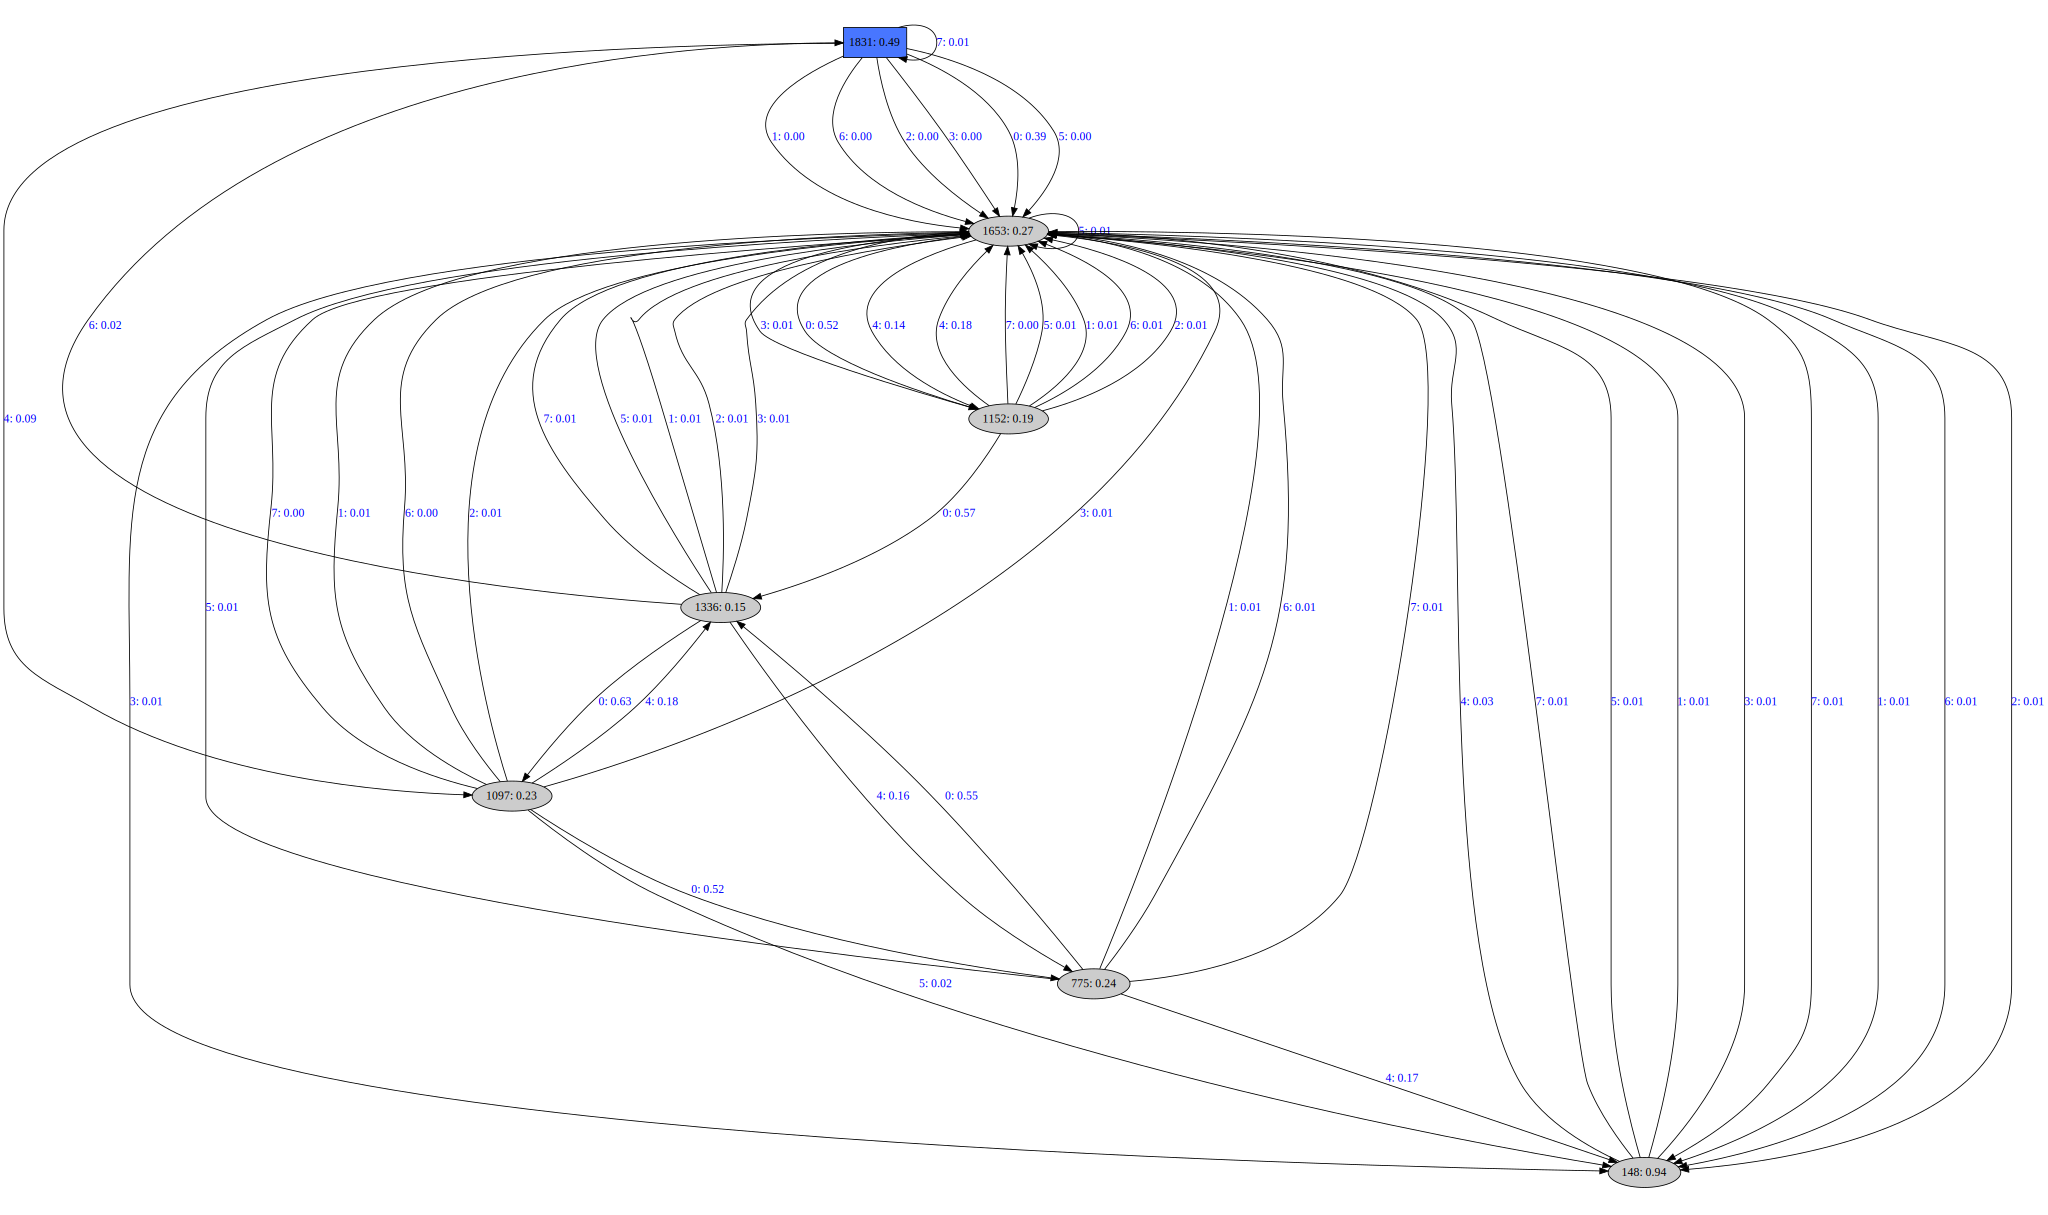

In [18]:
%autoreload 2
from wombats.automaton.pdfa import PDFA

learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object')
learned_pdfa.draw_IPython()

## Analyzing Learning Results with Wombats

Here, we want to use the wombats analysis tools to characterize the learning results